In [83]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')
#pd.set_option("display.max_columns",50)

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler
from sklearn.model_selection import cross_val_score,GridSearchCV,StratifiedKFold,RepeatedStratifiedKFold,RandomizedSearchCV
from sklearn.metrics import accuracy_score,auc,recall_score,precision_score,precision_recall_curve,confusion_matrix,\
plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve,classification_report
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.impute import SimpleImputer,KNNImputer
#from sklearn.compose import ColumnTransformer

In [3]:
path = "C:/Users/Krishna/Documents/kaggle/titanic/input"

##### Reading train csv

In [4]:
train = pd.read_csv(f'{path}/train.csv')
train.head(2)
train.shape

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


(891, 12)

In [5]:
train['Pclass'] = train['Pclass'].astype(str)
train.describe()
train.info()

,PassengerId,Survived,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null object
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 83.7+ KB


In [6]:
#train.Name.map(re.search("(.*)\\, (.*)\\.(.*) ").groups())
train['Surname'] = train.Name.map(str.upper).map(lambda x : re.search("(.*)\\, (.*?)\\.(.*)",x).group(2))

In [7]:
a = train.Surname.value_counts(normalize = True)>0.04
a = a[a!=True].index

#train.Surname[train.Surname.isin(a)] = 'Others'
train.Surname = np.where(~train.Surname.isin(a),train.Surname,'Others')
train.Surname.value_counts()

#train.Surname[~train.Surname.isin(a)] = train.Surname[~train.Sir_name.isin(a)].map(dict(zip(a,['Others']*len(a))))

MR        517
MISS      182
MRS       125
MASTER     40
Others     27
Name: Surname, dtype: int64

In [8]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,MR


In [9]:
train.Embarked = np.where(train.Embarked.isna(),train.Embarked.mode(dropna=True), train.Embarked)

train.Embarked.isna().sum()
train.Embarked.value_counts()

0

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [10]:
train[['Age_available']] = 1*train[['Age']].notna()
train['Cabin_type'] = train.Cabin.astype(str).apply(lambda x : x[0].upper()) #n means not available
train['Family_size'] = train.Parch + train.SibSp

In [11]:
test = pd.read_csv(f'{path}/test.csv')
test.head(2)
test.shape

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


(418, 11)

In [12]:
pd.crosstab(train['Surname'],train['Sex'],)

Sex,female,male
Surname,,
MASTER,0,40
MISS,182,0
MR,0,517
MRS,125,0
Others,7,20


In [13]:
train.groupby('Surname').Age.mean()

Surname
MASTER     4.574167
MISS      21.773973
MR        32.368090
MRS       35.898148
Others    42.384615
Name: Age, dtype: float64

In [14]:
train.groupby('Surname').Age.mean()
#train.Age.dropna().groupby(train.Surname, sort = True).mean()

train[train.Age.isna()].Surname.value_counts(sort = True)
#train[train.Age.isna()].groupby(train.Surname, sort = True).count()

Surname
MASTER     4.574167
MISS      21.773973
MR        32.368090
MRS       35.898148
Others    42.384615
Name: Age, dtype: float64

MR        119
MISS       36
MRS        17
MASTER      4
Others      1
Name: Surname, dtype: int64

In [15]:
test['Surname'] = test.Name.map(str.upper).map(lambda x : re.search("(.*)\\, (.*?)\\.(.*)",x).group(2))
test.Surname = np.where(test.Surname.isin(['MR','MISS','MRS','MASTER']),test.Surname,'Others')

test.Surname.isin(a).value_counts()
test['Surname'].value_counts()

False    418
Name: Surname, dtype: int64

MR        240
MISS       78
MRS        72
MASTER     21
Others      7
Name: Surname, dtype: int64

In [16]:
test[['Age_available']] = 1*test[['Age']].notna()
test['Cabin_type'] = test.Cabin.astype(str).apply(lambda x : x[0].upper()) #n means not available
test['Family_size'] = test.Parch + test.SibSp

In [17]:
test.groupby('Surname').Age.mean()
#test.Age.dropna().groupby(test.Surname, sort = False).mean()

test[test.Age.isna()].Surname.value_counts(sort = True)
#test.Age.isna().groupby(test.Surname, sort = False).sum()

Surname
MASTER     7.406471
MISS      21.774844
MR        32.000000
MRS       38.903226
Others    43.833333
Name: Age, dtype: float64

MR        57
MISS      14
MRS       10
MASTER     4
Others     1
Name: Surname, dtype: int64

In [18]:
train.loc[train.Age.isna(), 'Age'] = train[train.Age.isna()].Surname.map(train.groupby('Surname').Age.mean().to_dict())

In [19]:
test.Fare.isna().sum()
test['Fare'] = test.Fare.fillna(test.Fare.median())
test.Fare.isna().sum()

1

0

In [20]:
test.loc[test.Age.isna(), 'Age'] = test[test.Age.isna()].Surname.map(train.groupby('Surname').Age.mean().to_dict())

In [21]:
train.isna().sum()
test.isna().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            687
Embarked           0
Surname            0
Age_available      0
Cabin_type         0
Family_size        0
dtype: int64

PassengerId        0
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            327
Embarked           0
Surname            0
Age_available      0
Cabin_type         0
Family_size        0
dtype: int64

In [22]:
train[['Sex','Pclass', 'Embarked','Surname','Age_available','Cabin_type']] = train[['Sex','Pclass', 'Embarked','Surname','Age_available','Cabin_type']].astype(str)

test[['Sex','Pclass', 'Embarked','Surname','Age_available','Cabin_type']] = test[['Sex','Pclass', 'Embarked','Surname','Age_available','Cabin_type']].astype(str)

In [23]:
def dict_vec(train_set,cols,is_test, test_set):
    """
    returns dict vectorizer on train set or train & test set for chosen columns
    train_set: Dataset on which DV is to be fit
    cols: List of columns of train_set which are to be considered for DV
    is_test: Boolean, If DV is to be transformed on test too
    test_set: Test set on which DV is to be transformed
    """
    from sklearn.feature_extraction import DictVectorizer
    import pandas as pd
    dvec = DictVectorizer(sparse=False)
    if not is_test:
        test_set = pd.DataFrame()
        train_dvec = dvec.fit_transform(train_set[cols].transpose().to_dict().values())
        train_dvec = pd.DataFrame(train_dvec, index = train_set.index, columns = dvec.get_feature_names())
        train_df = pd.concat([train_set.drop(cols, axis = 1),train_dvec], axis = 1)
        return train_df,pd.DataFrame(),dvec
    else:
        train_dvec = dvec.fit_transform(train_set[cols].transpose().to_dict().values())
        train_dvec = pd.DataFrame(train_dvec, index = train_set.index, columns = dvec.get_feature_names())
        train_df = pd.concat([train_set.drop(cols, axis = 1),train_dvec], axis = 1)
        test_dvec = dvec.transform(test_set[cols].transpose().to_dict().values())
        test_dvec = pd.DataFrame(test_dvec, index = test_set.index, columns = dvec.get_feature_names())
        test_df = pd.concat([test_set.drop(cols, axis = 1),test_dvec], axis = 1)
        return train_df, test_df,dvec

In [24]:
train_df,test_df,dv = dict_vec(train, ['Sex','Pclass', 'Embarked','Surname','Age_available','Cabin_type'],is_test = True,test_set =test)

In [25]:
train_df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Family_size', 'Age_available=0', 'Age_available=1',
       'Cabin_type=A', 'Cabin_type=B', 'Cabin_type=C', 'Cabin_type=D',
       'Cabin_type=E', 'Cabin_type=F', 'Cabin_type=G', 'Cabin_type=N',
       'Cabin_type=T', 'Embarked=C', 'Embarked=Q', 'Embarked=S', 'Pclass=1',
       'Pclass=2', 'Pclass=3', 'Sex=female', 'Sex=male', 'Surname=MASTER',
       'Surname=MISS', 'Surname=MR', 'Surname=MRS', 'Surname=Others'],
      dtype='object')

In [26]:
target  = 'Survived'
features= train_df.drop(['PassengerId','Survived', 'Name','Ticket','Cabin','SibSp', 'Parch'], axis =1).columns
target
features

'Survived'

Index(['Age', 'Fare', 'Family_size', 'Age_available=0', 'Age_available=1',
       'Cabin_type=A', 'Cabin_type=B', 'Cabin_type=C', 'Cabin_type=D',
       'Cabin_type=E', 'Cabin_type=F', 'Cabin_type=G', 'Cabin_type=N',
       'Cabin_type=T', 'Embarked=C', 'Embarked=Q', 'Embarked=S', 'Pclass=1',
       'Pclass=2', 'Pclass=3', 'Sex=female', 'Sex=male', 'Surname=MASTER',
       'Surname=MISS', 'Surname=MR', 'Surname=MRS', 'Surname=Others'],
      dtype='object')

### splitting into train and test set

In [122]:

X_train,X_test,y_train,y_test = train_test_split(train_df[features],train_df[target],stratify = train_df[target],\
                                                 test_size=0.25, random_state=69)

### logreg on train set

In [28]:
logreg = make_pipeline(StandardScaler(), LogisticRegression(solver = 'lbfgs', max_iter=10000,C= 0.1))
#res = df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('.'))

In [29]:
logreg.fit(X_train[features], y_train);

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [30]:
pred_bin = logreg.predict(X_train[features])
pred_prob = logreg.predict_proba(X_train[features])[:,1]
logreg.score(X_train[features], y_train) # accuracy

0.8488023952095808

In [31]:
precision_score(y_train,pred_bin)
recall_score(y_train,pred_bin)
confusion_matrix(y_train,pred_bin)
accuracy_score(y_train,pred_bin)

0.8163265306122449

0.78125

array([[367,  45],
       [ 56, 200]], dtype=int64)

0.8488023952095808

### logreg on test

In [33]:
pred_bin = logreg.predict(X_test[features])
precision_score(y_test,pred_bin)
recall_score(y_test,pred_bin)
confusion_matrix(y_test,pred_bin)
accuracy_score(y_test,pred_bin)

0.8072289156626506

0.7790697674418605

array([[121,  16],
       [ 19,  67]], dtype=int64)

0.8430493273542601

In [162]:
recall_score(train_df[target],logreg.predict(train_df[features]))

0.7807017543859649

### The mean score and the 95% confidence interval of the score estimate are hence given by:

In [166]:
all_accuracies_data = cross_val_score(estimator=logreg, X=train_df[features], y=train_df[target], cv=5,scoring = 'f1_macro')
all_accuracies_data
print("Full Accuracy: %0.2f(+/- %0.2f)" % (all_accuracies_data.mean(), all_accuracies_data.std()*2))

all_accuracies_data = cross_val_score(estimator=logreg, X=train_df[features], y=train_df[target], cv=5,scoring = 'precision_macro')
all_accuracies_data
print("Full Accuracy: %0.2f(+/- %0.2f)" % (all_accuracies_data.mean(), all_accuracies_data.std()*2))

all_accuracies_data = cross_val_score(estimator=logreg, X=train_df[features], y=train_df[target], cv=5,scoring = 'recall_macro')
all_accuracies_data
print("Full Accuracy: %0.2f(+/- %0.2f)" % (all_accuracies_data.mean(), all_accuracies_data.std()*2))

array([0.81864235, 0.82049213, 0.80962567, 0.80594338, 0.85873016])

Full Accuracy: 0.82(+/- 0.04)


array([0.81652388, 0.82251082, 0.80962567, 0.8325283 , 0.85704884])

Full Accuracy: 0.83(+/- 0.03)


array([0.821278  , 0.81871658, 0.80962567, 0.79451872, 0.86065683])

Full Accuracy: 0.82(+/- 0.04)


In [36]:
np.bincount(logreg.predict(test_df[features]))

pd.concat([test_df[['PassengerId']],pd.DataFrame(logreg.predict(test_df[features]),columns= ['Survived'],\
               index = test_df.index)],axis = 1).to_csv(f'{path}/titanic_submit9lrpipe.csv', index=False)

array([251, 167], dtype=int64)

In [37]:
def logreg_coef(model,data):    
    """
    Gives the intercepts and coefficients along with variable names for logistic regression.
    model : name of the logistic model
    data :  data on which logistic model was fit, column order must be same as that of the
            data on which model was fit
    """
    intercept = pd.DataFrame({'variable' : 'intercept', 'coefficient' : model.intercept_})
    coefficient = pd.DataFrame({'variable' : data.columns, 'coefficient' : model.coef_.transpose().flatten()})
    coefficient = coefficient.reindex(coefficient.coefficient.abs().sort_values(ascending = False).index)
    return(pd.concat([intercept,coefficient], axis = 0).reset_index(drop = True))

lr_coefs = logreg_coef(model = logreg[1],data = train_df[features])
lr_coefs.head(7)

,variable,coefficient
0,intercept,-0.653631
1,Family_size,-0.550072
2,Surname=MR,-0.427699
3,Sex=male,-0.401073
4,Sex=female,0.401073
5,Surname=MASTER,0.370529
6,Surname=MRS,0.346439


# XGB

In [41]:

XGB = XGBClassifier(n_estimators = 500,learning_rate= 0.001,colsample_bytree= 0.75,subsample=0.9)
#XGB = RandomForestClassifier(n_estimators=750,oob_score=True,max_depth=6,max_features=10)
XGB



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0,
              learning_rate=0.001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [42]:
XGB.fit(X_train[features], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0,
              learning_rate=0.001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [45]:
pred_bin = XGB.predict(X_train)
precision_score(y_train,pred_bin)
recall_score(y_train,pred_bin)
confusion_matrix(y_train,pred_bin)
accuracy_score(y_train,pred_bin)

0.8099173553719008

0.765625

array([[366,  46],
       [ 60, 196]], dtype=int64)

0.8413173652694611

##### prediction on test

In [46]:
pred_bin = XGB.predict(X_test)
precision_score(y_test,pred_bin)
recall_score(y_test,pred_bin)
confusion_matrix(y_test,pred_bin)
accuracy_score(y_test,pred_bin)

0.7857142857142857

0.7674418604651163

array([[119,  18],
       [ 20,  66]], dtype=int64)

0.8295964125560538

### The mean score and the 95% confidence interval of the score estimate are hence given by:

In [165]:
all_accuracies_data = cross_val_score(estimator=XGB, X=train_df[features], y=train_df[target], cv=5,scoring = 'f1_macro')
all_accuracies_data
print("Full Accuracy: %0.2f(+/- %0.2f)" % (all_accuracies_data.mean(), all_accuracies_data.std()*2))

all_accuracies_data = cross_val_score(estimator=XGB, X=train_df[features], y=train_df[target], cv=5,scoring = 'precision_macro')
all_accuracies_data
print("Full Accuracy: %0.2f(+/- %0.2f)" % (all_accuracies_data.mean(), all_accuracies_data.std()*2))

all_accuracies_data = cross_val_score(estimator=XGB, X=train_df[features], y=train_df[target], cv=5,scoring = 'recall_macro')
all_accuracies_data
print("Full Accuracy: %0.2f(+/- %0.2f)" % (all_accuracies_data.mean(), all_accuracies_data.std()*2))

array([0.83946188, 0.80311714, 0.81395192, 0.77720559, 0.85084632])

Full Accuracy: 0.82(+/- 0.05)


array([0.84271923, 0.80402044, 0.81708645, 0.81371618, 0.85416667])

Full Accuracy: 0.83(+/- 0.02)


array([0.83675889, 0.80227273, 0.81136364, 0.76510695, 0.84809201])

Full Accuracy: 0.81(+/- 0.03)


In [47]:
pd.DataFrame({'features' : features, 'importance' : XGB.feature_importances_}).\
           sort_values('importance',ascending = False).head(10)

,features,importance
24,Surname=MR,0.204823
20,Sex=female,0.191553
21,Sex=male,0.167570
23,Surname=MISS,0.123521
25,Surname=MRS,0.048483
19,Pclass=3,0.042222
2,Family_size,0.037809
12,Cabin_type=N,0.022826
18,Pclass=2,0.022219
22,Surname=MASTER,0.018013


### for submitting

In [49]:
np.bincount(XGB.predict(test_df[features]))

pd.concat([test_df[['PassengerId']],pd.DataFrame(XGB.predict(test_df[features]),columns= ['Survived'],index = test_df.index)],axis = 1)\
.to_csv(f'{path}/titanic_submit10xgb.csv', index=False)

array([254, 164], dtype=int64)

# RF

In [120]:
X_train.shape
y_train.value_counts(normalize=True)

(668, 27)

0    0.616766
1    0.383234
Name: Survived, dtype: float64

In [201]:
#RF = RandomForestClassifier(n_estimators=750,oob_score=True,max_depth=6,max_features=8)
RF = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features=19,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=69, verbose=0,
                       warm_start=False)
RF.fit(X_train[features], y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features=19,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=69, verbose=0,
                       warm_start=False)

In [202]:
pred_bin = RF.predict(X_train)
precision_score(y_train,pred_bin)
recall_score(y_train,pred_bin)
confusion_matrix(y_train,pred_bin)
accuracy_score(y_train,pred_bin)

0.9310344827586207

0.84375

array([[396,  16],
       [ 40, 216]], dtype=int64)

0.9161676646706587

##### prediction on test

In [203]:
pred_bin = RF.predict(X_test)
precision_score(y_test,pred_bin)
recall_score(y_test,pred_bin)
confusion_matrix(y_test,pred_bin)
accuracy_score(y_test,pred_bin)

0.8

0.7441860465116279

array([[121,  16],
       [ 22,  64]], dtype=int64)

0.8295964125560538

### The mean score and the 95% confidence interval of the score estimate are hence given by:

In [204]:
all_accuracies_data = cross_val_score(estimator=RF, X=train_df[features], y=train_df[target], cv=5,scoring = 'f1_macro')
all_accuracies_data
print("Full Accuracy: %0.2f(+/- %0.2f)" % (all_accuracies_data.mean(), all_accuracies_data.std()*2))

all_accuracies_data = cross_val_score(estimator=RF, X=train_df[features], y=train_df[target], cv=5,scoring = 'precision_macro')
all_accuracies_data
print("Full Accuracy: %0.2f(+/- %0.2f)" % (all_accuracies_data.mean(), all_accuracies_data.std()*2))

all_accuracies_data = cross_val_score(estimator=RF, X=train_df[features], y=train_df[target], cv=5,scoring = 'recall_macro')
all_accuracies_data
print("Full Accuracy: %0.2f(+/- %0.2f)" % (all_accuracies_data.mean(), all_accuracies_data.std()*2))

array([0.83090418, 0.79400953, 0.8490246 , 0.78450363, 0.83433054])

Full Accuracy: 0.82(+/- 0.05)


array([0.8417616 , 0.80088988, 0.85541753, 0.8184375 , 0.83433054])

Full Accuracy: 0.83(+/- 0.04)


array([0.82411067, 0.78930481, 0.84425134, 0.77245989, 0.83433054])

Full Accuracy: 0.81(+/- 0.05)


In [205]:
pd.DataFrame({'features' : features, 'importance' : RF.feature_importances_}).\
           sort_values('importance',ascending = False).head(10)

,features,importance
24,Surname=MR,0.205599
1,Fare,0.165942
0,Age,0.132533
21,Sex=male,0.106785
20,Sex=female,0.104586
2,Family_size,0.081168
19,Pclass=3,0.064158
12,Cabin_type=N,0.019798
17,Pclass=1,0.014900
9,Cabin_type=E,0.013699


In [206]:
np.bincount(RF.predict(test_df[features]))

pd.concat([test_df[['PassengerId']],pd.DataFrame(RF.predict(test_df[features]),columns= ['Survived'],index = test_df.index)],axis = 1)\
.to_csv(f'{path}/titanic_submit13rfgs.csv', index=False)

array([265, 153], dtype=int64)

# stacked model

In [126]:
estimators = [('rf', RandomForestClassifier(n_estimators=750,oob_score=True,max_depth=6,max_features=8)),
 #   ('svr', make_pipeline(StandardScaler(),LinearSVC(random_state=42))),
    ('knn', make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=5))),
    ('lr', make_pipeline(StandardScaler(), LogisticRegression(solver = 'lbfgs', max_iter=10000,C= 0.1))),
    ('XGB', XGBClassifier(n_estimators = 500,learning_rate= 0.001,colsample_bytree= 0.75,subsample=0.9))]

In [127]:
clf = StackingClassifier(
    estimators=estimators, final_estimator=RandomForestClassifier(n_estimators=750,oob_score=True,\
                                                                  max_depth=6,max_features=8),cv = 5,passthrough=True)

In [128]:
clf.fit(X_train[features], y_train);

In [129]:
pred_bin = clf.predict(X_train)
precision_score(y_train,pred_bin)
recall_score(y_train,pred_bin)
confusion_matrix(y_train,pred_bin)
accuracy_score(y_train,pred_bin)

0.8839285714285714

0.7734375

array([[386,  26],
       [ 58, 198]], dtype=int64)

0.874251497005988

##### prediction on test

In [130]:
pred_bin = clf.predict(X_test)
precision_score(y_test,pred_bin)
recall_score(y_test,pred_bin)
confusion_matrix(y_test,pred_bin)
accuracy_score(y_test,pred_bin)

0.8227848101265823

0.7558139534883721

array([[123,  14],
       [ 21,  65]], dtype=int64)

0.8430493273542601

### The mean score and the 95% confidence interval of the score estimate are hence given by:

In [168]:
all_accuracies_data = cross_val_score(estimator=clf, X=train_df[features], y=train_df[target], cv=5,scoring = 'f1_macro')
all_accuracies_data
print("Full Accuracy: %0.2f(+/- %0.2f)" % (all_accuracies_data.mean(), all_accuracies_data.std()*2))

all_accuracies_data = cross_val_score(estimator=clf, X=train_df[features], y=train_df[target], cv=5,scoring = 'precision_macro')
all_accuracies_data
print("Full Accuracy: %0.2f(+/- %0.2f)" % (all_accuracies_data.mean(), all_accuracies_data.std()*2))

all_accuracies_data = cross_val_score(estimator=clf, X=train_df[features], y=train_df[target], cv=5,scoring = 'recall_macro')
all_accuracies_data
print("Full Accuracy: %0.2f(+/- %0.2f)" % (all_accuracies_data.mean(), all_accuracies_data.std()*2))

array([0.83199249, 0.78962736, 0.82372025, 0.77521198, 0.83036079])

Full Accuracy: 0.81(+/- 0.05)


array([0.84449728, 0.80752342, 0.82782486, 0.82323718, 0.84872881])

Full Accuracy: 0.83(+/- 0.03)


array([0.82681159, 0.78088235, 0.81764706, 0.77700535, 0.82828081])

Full Accuracy: 0.81(+/- 0.05)


In [132]:
np.bincount(clf.predict(test_df[features]))

pd.concat([test_df[['PassengerId']],pd.DataFrame(clf.predict(test_df[features]),columns= ['Survived'],index = test_df.index)],axis = 1)\
.to_csv(f'{path}/titanic_submit12rstk_clf.csv', index=False)

array([263, 155], dtype=int64)

# plotting roc curve

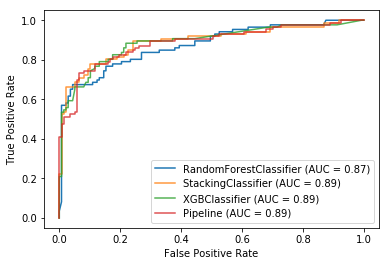

In [154]:
rf_disp = plot_roc_curve(RF, X_test, y_test)
ax = plt.gca()
stk_disp = plot_roc_curve(clf, X_test, y_test, ax=ax, alpha=0.8)
xgb_disp = plot_roc_curve(XGB, X_test, y_test, ax=ax, alpha=0.8)
lr_disp = plot_roc_curve(logreg, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

# plotting precision recall curve

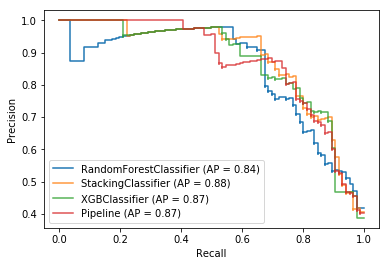

In [141]:
rf_disp = plot_precision_recall_curve(RF, X_test, y_test)
ax = plt.gca()
stk_disp = plot_precision_recall_curve(clf, X_test, y_test, ax=ax, alpha=0.8)
xgb_disp = plot_precision_recall_curve(XGB, X_test, y_test, ax=ax, alpha=0.8)
lr_disp = plot_precision_recall_curve(logreg, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

# Grid Search on RF

In [185]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [197]:
# Set the parameters by cross-validation
param_grid = [{'n_estimators': [100,200,300,400,500,600,700,800]}, {'oob_score': [False, True]},
                     {'max_depth': [3,5,6,7,8,9,10], 'max_features' : [6,8,10,12,15,17,18,19,20,21]}]


rf_gs = GridSearchCV(RandomForestClassifier(random_state = 69),param_grid,n_jobs=-1,cv = 10, scoring='precision_macro')
rf_gs.fit(X_train, y_train)


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=69,
                                 

In [209]:
rf_gs.best_estimator_
rf_gs.best_params_
rf_gs.best_score_
rf_gs.best_index_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features=19,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=69, verbose=0,
                       warm_start=False)

{'max_depth': 7, 'max_features': 19}

0.8383474413713999

47

In [ ]:
GS_perf = pd.DataFrame()
GS_perf['Parameters'] = rf_gs.cv_results_['params']
GS_perf.head(79)

In [199]:

print("Best parameters set found on development set:")
print()
print(rf_gs.best_params_)
print()
print("Grid scores on development set:")
print()
means = rf_gs.cv_results_['mean_test_score']
stds = rf_gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, rf_gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"  % (mean, std * 2, params))
print()

Best parameters set found on development set:

{'max_depth': 7, 'max_features': 19}

Grid scores on development set:

0.801 (+/-0.084) for {'n_estimators': 100}
0.803 (+/-0.060) for {'n_estimators': 200}
0.798 (+/-0.072) for {'n_estimators': 300}
0.800 (+/-0.074) for {'n_estimators': 400}
0.800 (+/-0.077) for {'n_estimators': 500}
0.797 (+/-0.075) for {'n_estimators': 600}
0.798 (+/-0.075) for {'n_estimators': 700}
0.797 (+/-0.071) for {'n_estimators': 800}
0.801 (+/-0.084) for {'oob_score': False}
0.801 (+/-0.084) for {'oob_score': True}
0.805 (+/-0.128) for {'max_depth': 3, 'max_features': 6}
0.818 (+/-0.103) for {'max_depth': 3, 'max_features': 8}
0.819 (+/-0.100) for {'max_depth': 3, 'max_features': 10}
0.824 (+/-0.094) for {'max_depth': 3, 'max_features': 12}
0.823 (+/-0.084) for {'max_depth': 3, 'max_features': 15}
0.815 (+/-0.097) for {'max_depth': 3, 'max_features': 17}
0.817 (+/-0.095) for {'max_depth': 3, 'max_features': 18}
0.815 (+/-0.099) for {'max_depth': 3, 'max_features

In [224]:

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, rf_gs.predict(X_test)
print(classification_report(y_true, y_pred))
print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       137
           1       0.80      0.74      0.77        86

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.82       223
weighted avg       0.83      0.83      0.83       223




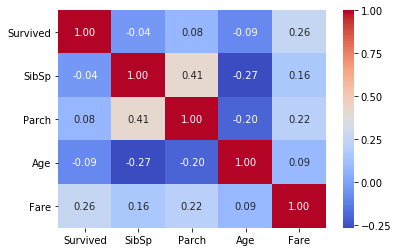

In [225]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
import seaborn as sns
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

# GGGGGGGAAAAAAAAAAAAARBAGE

In [ ]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring

In [ ]:
https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
    https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV
    https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

In [56]:
all_accuracies_train = cross_val_score(estimator=XGB, X=X_train, y=y_train, cv=5)
all_accuracies_train
print("Train Accuracy: %0.2f (+/- %0.2f)" % (all_accuracies_train.mean(), all_accuracies_train.std() * 2))

all_accuracies_test = cross_val_score(estimator=XGB, X=X_test, y=y_test, cv=5)
all_accuracies_test
print("Test Accuracy: %0.2f(+/- %0.2f)" % (all_accuracies_test.mean(), all_accuracies_test.std()*2))

array([0.85074627, 0.82089552, 0.82835821, 0.81203008, 0.81203008])

Train Accuracy: 0.82 (+/- 0.03)


array([0.88888889, 0.77777778, 0.77777778, 0.88636364, 0.81818182])

Test Accuracy: 0.83(+/- 0.05)


In [ ]:
plt.subplot(121)

# equivalent but more general
ax1=plt.subplot(121,facecolor='red')

# add a subplot with no frame
ax2=plt.subplot(122,  projection='polar')

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.add_subplot(121)   #top left
fig.add_subplot(122)   #top right
plt.show()